# iCOM1

> Georgios Varnavides | 07/22/2024
> 
> Shahar Seifer | 08/03/2024

### Imports

In [1]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

0.14.15


In [26]:
# User Settings

scan_width=1024
scan_height=1024

R_pixel = 20 # A
SemiConvAngle = 4.0 # [mrad]
AccVoltage = 200e3 # [V]
defocus=0  # A

#comRotationForce = 0 # [degrees]
#comTransposeForce = False
comRotationForce = -90.0 # [degrees]
comTransposeForce = True #changed for new Arina

datasetScanSize = (scan_width,scan_height)
file_path = '/storwis/Labs/cpelbaum/shared/ArinaData/2024July30_layers/'
file_data = file_path+'2024Jul30_AD116_3_tomo16_s0_master.h5' 

batchSize = 1024
dataset=py4DSTEM.import_file(
    filepath=file_data,
    scan_width=scan_width,
)

In [27]:
file_data

'/storwis/Labs/cpelbaum/shared/ArinaData/2024July30_layers/2024Jul30_AD116_3_tomo16_s0_master.h5'

In [28]:
dataset


DataCube( A 4-dimensional array of shape (1024, 1024, 96, 96) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

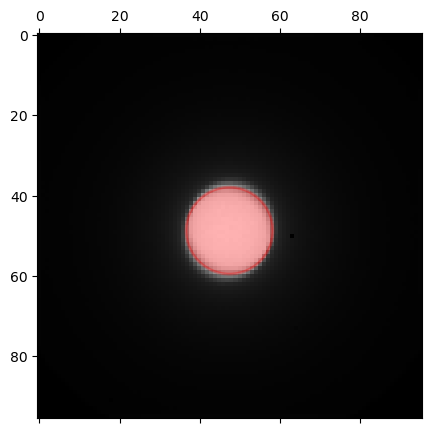

In [29]:


dataset.data[dataset.data>300]=0

dataset.get_dp_mean();
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(plot = True)





In [30]:
crop_ys=35
crop_ye=63
crop_xs=35
crop_xe=61
dataset.crop_Q((crop_ys,crop_ye,crop_xs,crop_xe))



dataset.calibration.set_R_pixel_size(R_pixel)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(SemiConvAngle / probe_semiangle)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.get_dp_mean();

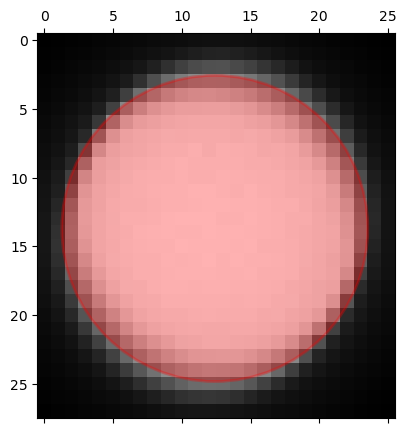

In [31]:
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(plot = True)

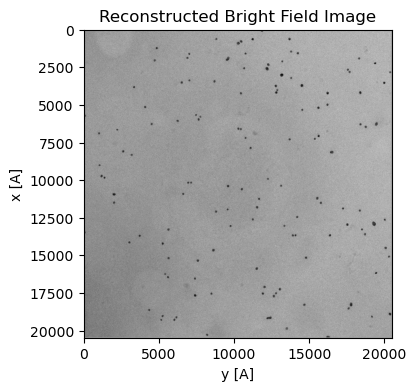

In [32]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = 200e3,
    verbose=False,
    object_padding_px=(8,8),
).preprocess(
    edge_blend=4,
    plot_average_bf=False,
    normalize_images=False,
    defocus_guess=0, #-defocus, # known defocus (no need to reconstruct anymore)
    rotation_guess=0, # known rotation (no need to reconstruct anymore)
).visualize(
    cmap='gray',
    figsize=(4,4)
)

In [33]:
# parallax.aberration_fit()
# parallax.aberration_correct()

In [36]:
from types import MethodType

def shifted_stack_to_datacube(
    self,
    shifted_stack = None,
):
    """ """
    if shifted_stack is None:
        shifted_stack = self._stack_BF_shifted
        
    pad_x_left = self._object_padding_px[0] // 2
    pad_x_right = pad_x_left - self._object_padding_px[0]
    pad_y_left = self._object_padding_px[1] // 2
    pad_y_right = pad_y_left - self._object_padding_px[1]

    cropped_BF_stack = shifted_stack[:,pad_x_left:pad_x_right,pad_y_left:pad_y_right]

    shifted_dataset = self._datacube.copy()
    shifted_dataset.data[:,:,self._xy_inds[:,0],self._xy_inds[:,1]] = cropped_BF_stack.transpose((1,2,0))
    
    return shifted_dataset




- First 4Ddata : "parallax-corrected" Virtual BFs

Reconstructing phase:  39%|████████████████████████████████████▎                                                        | 25/64 [00:08<00:12,  3.05 iter/s]


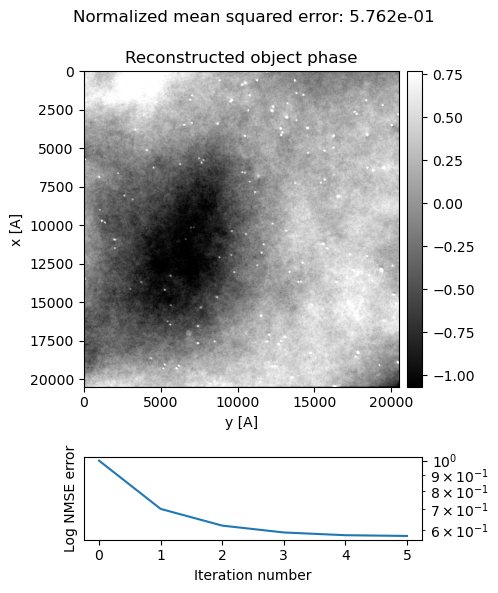

In [37]:
parallax.shifted_stack_to_datacube = MethodType(shifted_stack_to_datacube, parallax)
dc_1U = parallax.shifted_stack_to_datacube(parallax._stack_BF_unshifted)
dpc_1U = py4DSTEM.process.phase.DPC(
    dc_1U,
    energy=200e3,
    verbose=False,
).preprocess(
    force_com_rotation=comRotationForce,
    force_com_transpose=comRotationForce,
    plot_center_of_mass=False,
).reconstruct(
    reset=True,
    gaussian_filter= True,
    butterworth_filter = False,
    q_lowpass=0.5,
    q_highpass=0.0003,
    #gaussian_filter_sigma = 1,
    progress_bar=True,
    #max_iter = 1,
    #step_size = 2,
).visualize(
    cmap='gray'
)

In [38]:
dpc_1U

DPC( A Node called 'dpc_reconstruction', containing the following top-level objects in its tree:

)

- Second 4D-data: additional dz shift

In [39]:
dz = -500

xp = parallax._xp
im_depth = xp.zeros_like(parallax._recon_BF, dtype=xp.complex64)
dx = -parallax._probe_angles[:, 0] * dz / parallax._scan_sampling[0]
dy = -parallax._probe_angles[:, 1] * dz / parallax._scan_sampling[1]
qx = xp.fft.fftfreq(scan_width+8, 1)
qy = xp.fft.fftfreq(scan_height+8, 1)
qx = xp.asarray(qx, dtype=xp.float32)
qy = xp.asarray(qy, dtype=xp.float32)
qxa, qya = np.meshgrid(qx, qy, indexing="ij")
qx_shift = -2j * xp.pi * qxa
qy_shift = -2j * xp.pi * qya
shift_op = xp.exp(
    qx_shift * dx[:, None, None]
    + qy_shift * dy[:, None, None]
)
shifted_stack = xp.real(xp.fft.ifft2(xp.fft.fft2(parallax._stack_BF_unshifted) * shift_op))



dc_2 = parallax.shifted_stack_to_datacube(shifted_stack)

Reconstructing phase:  39%|████████████████████████████████████▎                                                        | 25/64 [00:32<00:50,  1.29s/ iter]


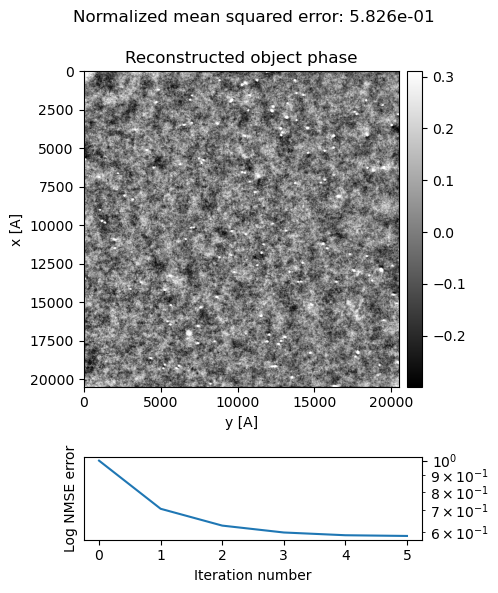

In [40]:
dpc_2 = py4DSTEM.process.phase.DPC(
    dc_2,
    energy=200e3,
    verbose=False,
).preprocess(
    force_com_rotation=comRotationForce,
    force_com_transpose=comRotationForce,
    plot_center_of_mass=False
).reconstruct(
    reset=True,
    gaussian_filter= False,
    butterworth_filter = True,
    q_lowpass=0.5,
    q_highpass=0.0003,
    #gaussian_filter_sigma = 1,
    progress_bar=True,
    #max_iter = 50,
    #step_size = 1,
    #clear_fft_cache: bool = None,
 
).visualize(
    cmap='gray'
)

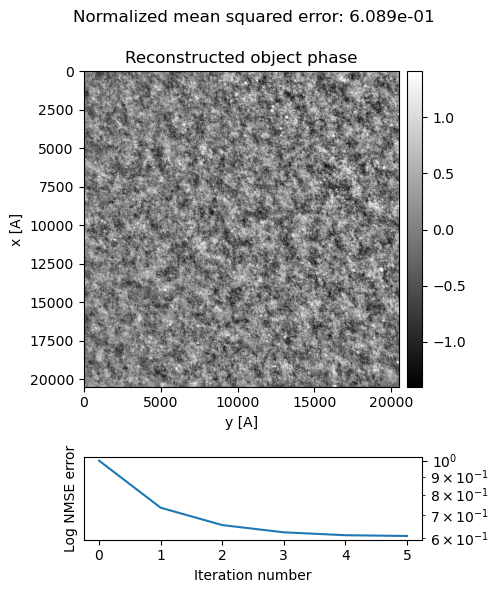

In [41]:
dz = -1000

xp = parallax._xp
im_depth = xp.zeros_like(parallax._recon_BF, dtype=xp.complex64)
dx = -parallax._probe_angles[:, 0] * dz / parallax._scan_sampling[0]
dy = -parallax._probe_angles[:, 1] * dz / parallax._scan_sampling[1]
qx = xp.fft.fftfreq(scan_width+8, 1)
qy = xp.fft.fftfreq(scan_height+8, 1)
qx = xp.asarray(qx, dtype=xp.float32)
qy = xp.asarray(qy, dtype=xp.float32)
qxa, qya = np.meshgrid(qx, qy, indexing="ij")
qx_shift = -2j * xp.pi * qxa
qy_shift = -2j * xp.pi * qya
shift_op = xp.exp(
    qx_shift * dx[:, None, None]
    + qy_shift * dy[:, None, None]
)
shifted_stack = xp.real(xp.fft.ifft2(xp.fft.fft2(parallax._stack_BF_unshifted) * shift_op))



dc_2b = parallax.shifted_stack_to_datacube(shifted_stack)
dpc_2b = py4DSTEM.process.phase.DPC(
    dc_2b,
    energy=200e3,
    verbose=False,
).preprocess(
    force_com_rotation=comRotationForce,
    force_com_transpose=comRotationForce,
    plot_center_of_mass=False
).reconstruct(
    reset=True,
    q_lowpass=0.5,
    q_highpass=0.0003,
    progress_bar=False,
).visualize(
    cmap='gray'
)

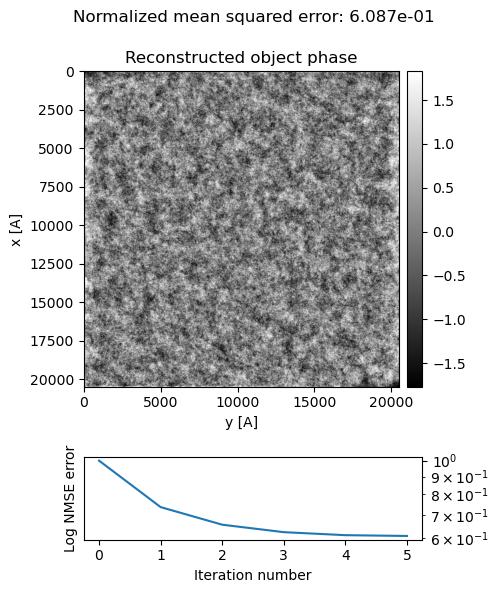

In [42]:
dz = -5000

xp = parallax._xp
im_depth = xp.zeros_like(parallax._recon_BF, dtype=xp.complex64)
dx = -parallax._probe_angles[:, 0] * dz / parallax._scan_sampling[0]
dy = -parallax._probe_angles[:, 1] * dz / parallax._scan_sampling[1]
qx = xp.fft.fftfreq(scan_width+8, 1)
qy = xp.fft.fftfreq(scan_height+8, 1)
qx = xp.asarray(qx, dtype=xp.float32)
qy = xp.asarray(qy, dtype=xp.float32)
qxa, qya = np.meshgrid(qx, qy, indexing="ij")
qx_shift = -2j * xp.pi * qxa
qy_shift = -2j * xp.pi * qya
shift_op = xp.exp(
    qx_shift * dx[:, None, None]
    + qy_shift * dy[:, None, None]
)
shifted_stack = xp.real(xp.fft.ifft2(xp.fft.fft2(parallax._stack_BF_unshifted) * shift_op))



dc_2e = parallax.shifted_stack_to_datacube(shifted_stack)
dpc_2e = py4DSTEM.process.phase.DPC(
    dc_2e,
    energy=200e3,
    verbose=False,
).preprocess(
    force_com_rotation=comRotationForce,
    force_com_transpose=comRotationForce,
    plot_center_of_mass=False
).reconstruct(
    q_lowpass=0.5,
    q_highpass=0.0003,
    progress_bar=False,
).visualize(
    cmap='gray'
)

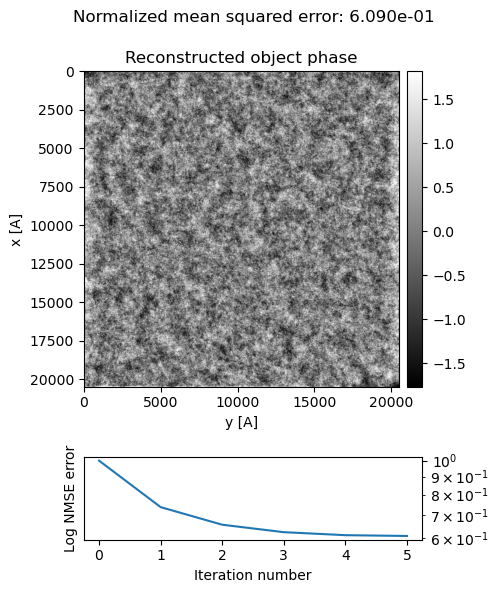

In [49]:
dz = -5500

xp = parallax._xp
im_depth = xp.zeros_like(parallax._recon_BF, dtype=xp.complex64)
dx = -parallax._probe_angles[:, 0] * dz / parallax._scan_sampling[0]
dy = -parallax._probe_angles[:, 1] * dz / parallax._scan_sampling[1]
qx = xp.fft.fftfreq(scan_width+8, 1)
qy = xp.fft.fftfreq(scan_height+8, 1)
qx = xp.asarray(qx, dtype=xp.float32)
qy = xp.asarray(qy, dtype=xp.float32)
qxa, qya = np.meshgrid(qx, qy, indexing="ij")
qx_shift = -2j * xp.pi * qxa
qy_shift = -2j * xp.pi * qya
shift_op = xp.exp(
    qx_shift * dx[:, None, None]
    + qy_shift * dy[:, None, None]
)
shifted_stack = xp.real(xp.fft.ifft2(xp.fft.fft2(parallax._stack_BF_unshifted) * shift_op))



dc_2f = parallax.shifted_stack_to_datacube(shifted_stack)
dpc_2f = py4DSTEM.process.phase.DPC(
    dc_2f,
    energy=200e3,
    verbose=False,
).preprocess(
    force_com_rotation=comRotationForce,
    force_com_transpose=comRotationForce,
    plot_center_of_mass=False
).reconstruct(
    q_lowpass=0.5,
    q_highpass=0.0003,
    progress_bar=False,
).visualize(
    cmap='gray'
)

In [44]:
#In a loop need to delete all the variables to release memory
# delete ...
import sys
import gc
gc.collect()

14467

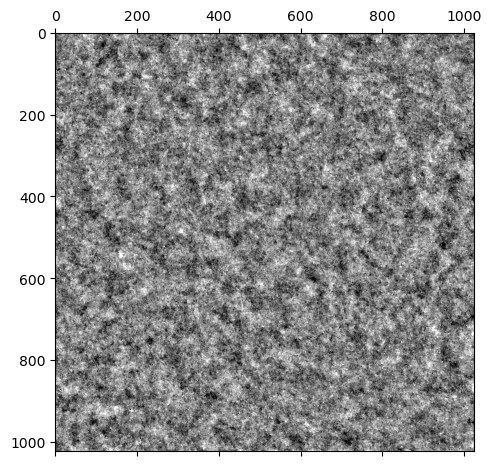

In [50]:

py4DSTEM.show(
    dpc_2f.object_phase - dpc_2e.object_phase
)

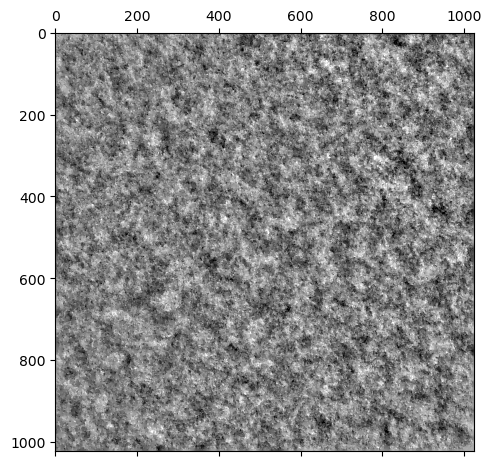

In [48]:
py4DSTEM.show(
    dpc_2.object_phase - dpc_2b.object_phase
)